<a href="https://colab.research.google.com/github/SivenM/mobilev1_unet/blob/master/pb_to_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

In [3]:
MODEL_PATH = '/content/drive/My Drive/unet_project/MN1_Unet5/test_weights'

In [5]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [7]:
!cp /content/model.tflite '/content/drive/My Drive/unet_project/MN1_Unet5/'

Test tflite model.

In [12]:
from tensorflow.keras.preprocessing import image
import matplotlib.pylab as plt

In [15]:
def get_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    return img

def preproc_img_to_model(img_path):
    img = get_img(img_path)
    img_tensor = image.img_to_array(img)
    img_tensor /= 255.
    img_tensor = np.expand_dims(img_tensor, axis=0)
    return img_tensor

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def predToGrayImage(predicted):
    img = np.zeros((predicted.shape[0], predicted.shape[1], 3))
    img[:, :, 0] = predicted[:, :, 0] * 254
    img[:, :, 1] = img[:, :, 0]  # Make greyscale
    img[:, :, 2] = img[:, :, 0]  # Make greyscale
    return img.astype('uint8')

def visualise_predict(img, predict):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(predict)
    ax2.axis('off')
    plt.show()

In [8]:
interpreter = tf.lite.Interpreter('/content/model.tflite')
interpreter.allocate_tensors()

In [9]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [14]:
test_img_path = '/content/drive/My Drive/musk.png'

In [20]:
img_tensor = preproc_img_to_model(test_img_path)

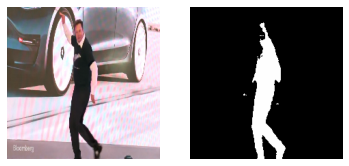

In [32]:
interpreter.set_tensor(input_details[0]['index'], img_tensor)
interpreter.invoke()
tflite_result = interpreter.get_tensor(output_details[0]['index'])
msk_predicted = create_mask(tflite_result)

msk_predicted = predToGrayImage(msk_predicted)
visualise_predict(img_tensor[0], msk_predicted)